In [7]:
from rdkit import Chem
from rdkit.Chem.rdchem import BondType as BT


In [8]:
import torch
print(torch.__version__)
import torch.nn.functional as F
from torch_sparse import coalesce
from torch_geometric.data import Data

2.0.1


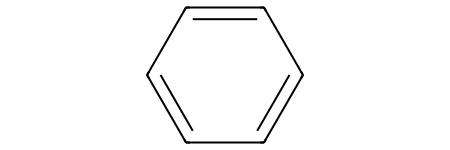

In [27]:
benzene_smi = "c1ccccc1"
benzene_mol = Chem.MolFromSmiles(benzene_smi)
benzene_mol

In [28]:

def load_zinc(zinc_mols):
    '''
    Takes as input a list of molecules objs (either ../data/ZINC_mols_train or ZINC_mols_test) and
    returns a list of PyG observations already one-hot encoded
    '''

    types = {
        'C': 0,
        'O': 1,
        'N': 2,
        'F': 3,
        'S': 4,
        'Cl': 5,
        'Br': 6,
        'I': 7,
        'P': 8
    }

    # bonds = {
    #     BT.SINGLE: 0,
    #     BT.DOUBLE: 1,
    #     BT.TRIPLE: 2,
    #     BT.AROMATIC: 3        
    # }


    bonds = {
        BT.SINGLE: 0,
        BT.DOUBLE: 1,
        BT.TRIPLE: 2,
        BT.AROMATIC: 1        
    }



    data_list = []
    for i, mol in enumerate(zinc_mols):
        if mol is None:
            continue

        N = mol.GetNumAtoms()

        type_idx = []
        for atom in mol.GetAtoms():
            type_idx.append(types[atom.GetSymbol()])

        x = F.one_hot(torch.tensor(type_idx), num_classes=len(types))
        row, col, bond_idx = [], [], []
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            row += [start, end]
            col += [end, start]
            bond_idx += 2 * [bonds[bond.GetBondType()]]

        edge_index = torch.tensor([row, col], dtype=torch.long)
        edge_attr = F.one_hot(torch.tensor(bond_idx).to(torch.int64),
                              num_classes=len(bonds)).to(torch.float)
        edge_index, edge_attr = coalesce(edge_index, edge_attr, N, N)

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data_list.append(data)

    return data_list

In [29]:
data = load_zinc([benzene_mol])
benzene_pyg = data[0]
benzene_pyg

Data(x=[6, 9], edge_index=[2, 12], edge_attr=[12, 4])

In [30]:
benzene_pyg.x

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [31]:
benzene_pyg.edge_index

tensor([[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
        [1, 5, 0, 2, 1, 3, 2, 4, 3, 5, 0, 4]])

In [32]:
benzene_pyg.edge_attr

tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])